<a href="https://colab.research.google.com/github/Hajaarh/malaria_hematie_cnn/blob/main/malaria_deeplearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* AOURACHI Yassine
* HAILAF Hajar
* DIA2

#Projet CNN: Classification d'images médicales à l'aide de reseaux de neurones convolutifs


##Importation des bibliothèques et extraction des données zip


In [1]:
# Google Drive et importation des bibliothèques nécessaires

from google.colab import drive
drive.mount('/content/drive')

import zipfile
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau,  ModelCheckpoint

# Pour VGG16 et ResNet50
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input as resnet_preprocess

print("Imports terminés.")


Mounted at /content/drive
Imports terminés.


In [2]:
# 1) Extraire les données ZIP et explorer la structure
zip_chemin = "/content/drive/MyDrive/Colab Notebooks/malaria_hematie_dataset.zip"
extraction = "/content/malaria_hematie_dataset"

# Extraire le fichier ZIP
with zipfile.ZipFile(zip_chemin, 'r') as zip_ref:
    zip_ref.extractall(extraction)

print("Données extraites dans :", extraction)


Données extraites dans : /content/malaria_hematie_dataset


In [3]:
# 2) Charger les images et labels
base_dir = "/content/malaria_hematie_dataset/malaria_hematie_dataset"

data = []
for class_name in os.listdir(base_dir):
    class_dir = os.path.join(base_dir, class_name)
    if os.path.isdir(class_dir):  # Vérifie si c'est un dossier
        for file_name in os.listdir(class_dir):
            file_path = os.path.join(class_dir, file_name)
            data.append([file_path, class_name])

# Création du DataFrame
df = pd.DataFrame(data, columns=['filepath', 'label'])

df.head()

,filepath,label
0,/content/malaria_hematie_dataset/malaria_hemat...,uninfected
1,/content/malaria_hematie_dataset/malaria_hemat...,uninfected
2,/content/malaria_hematie_dataset/malaria_hemat...,uninfected
3,/content/malaria_hematie_dataset/malaria_hemat...,uninfected
4,/content/malaria_hematie_dataset/malaria_hemat...,uninfected


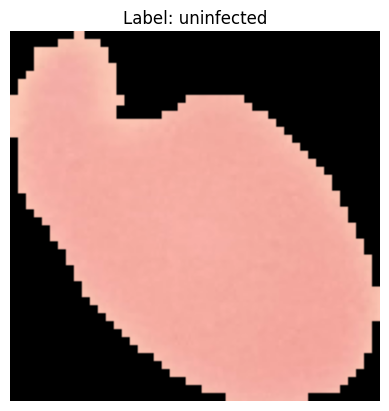

In [4]:
# Sélection des chemins des fichiers images pour afficher deux images côte à côte
image_path = [df.iloc[0]['filepath'], df.iloc[1]['filepath']]
labels = [df.iloc[0]['label'], df.iloc[1]['label']]

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

for i, ax in enumerate(axes):
    image = cv2.imread(image_path[i])  # Lire l'image
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convertir en RGB

    ax.imshow(image)  # Afficher l'image
    ax.set_title(f"Label: {labels[i]}")  # Ajouter le label comme titre
    ax.axis("off")  # Masquer les axes

plt.tight_layout()  # Ajuster les marges
plt.show()

In [5]:
# # Conserver l'intégralité du dataset sans le modifier
# df_full = df.copy()  # Sauvegarde le dataset original

# # Sous-échantillonner des images
# fraction = 0.3
# df = df.sample(frac=fraction, random_state=42)  # Sélection aléatoire

# # Vérifier la réduction du dataset
# print(f"Images avant échantillonnage : {len(df_full)}")
# print(f"Images après échantillonnage  : {len(df)}")

In [6]:
# 3) Séparer en train / temp (val + test)
df_train, df_temp = train_test_split(df, test_size=0.3265, stratify=df['label'], random_state=42)

# Séparer temp en val / test
df_val, df_test = train_test_split(df_temp, test_size=0.459, stratify=df_temp['label'], random_state=42)

print(f"Train : {len(df_train)}, Validation : {len(df_val)}, Test : {len(df_test)}")


Train : 18560, Validation : 4867, Test : 4131


In [7]:
print(f"Nombre total d'images : {len(df)}") # Compter le nombre de total d'images

Nombre total d'images : 27558


In [8]:
unique, counts = np.unique(df['label'], return_counts=True)  # Récupérer les classes et le nombre d'images
print(dict(zip(unique, counts)))  # Nombre de healthy / sick

{'parasitized': 13779, 'uninfected': 13779}


In [9]:
df_labels = df['label']
print(df_labels.value_counts(normalize=True) * 100) # Affiche les proportions % de chaque classe

label
uninfected     50.0
parasitized    50.0
Name: proportion, dtype: float64


In [10]:
def random_grayscale(image):
    if np.random.rand() < 0.3:  # 30% des images seront converties en niveaux de gris
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)  # Convertir en niveaux de gris
        image = np.expand_dims(image, axis=-1)  # Pour garder le format (H, W, 1)
    return image  # Retourne l'image (RGB ou grayscale)

# Data Augmentation
Ce qu'on a voulu faire en paramétrant la data augmentation, en raison de la coloration et de son changement entre l’apprentissage et l’ensemble de données, notre modèle gère les deux cas : RGB et grayscale.

Donc, la stratégie a été de générer une version des images en gris et de les mélanger avec les images RGB dans le dataset d'entraînement.

Aussi, l'énorme complication c'est d'optimiser ce code afin de ne pas faire appel à toutes les images et les charger en mémoire RAM.

Après plusieurs essais, plusieurs échecs, on a réussi à trouver de la documentation. On a utilisé flow_from_directory() pour appeler les images en temps réel et éviter de charger tout le dataset.


## Séparation des données en trois parties

Dans notre code, ImageDataGenerator est utilisé uniquement pour la validation et le test, on a appliqué uniquement la normalisation 'rescale'.


In [11]:
# 4) Normalisation et Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalisation
    preprocessing_function=random_grayscale,  # Mélanger couleurs et niveaux de gris des images pour que le modèle puisse gérer les 2 cas
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.3,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='constant',  # Remplissage constant
    cval=0, # Pour le fond noir
    brightness_range=[0.85, 1.15] # Pour la luminosité
)

val_test_datagen = ImageDataGenerator(rescale=1./255)  # Normalisation pour val/test

#  Economie de mémoire pour ne pas charger tout le dataset en utilisant train_generator
#  En générant un batch aléatoire àchaque exécution
train_generator = train_datagen.flow_from_dataframe( # Appliqué uniquement pour l'entrainement
    dataframe=df_train,
    x_col="filepath",
    y_col="label",
    target_size=(130, 130),
    batch_size=128,
    class_mode="binary",  # Pour classification binaire
    shuffle=True,
)


# Utilisé pour la validation et le test
val_generator = val_test_datagen.flow_from_dataframe(
    dataframe=df_val,
    x_col="filepath",
    y_col="label",
    target_size=(130, 130),
    batch_size=128,
    class_mode="binary",
    shuffle=False
)

test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=df_test,
    x_col="filepath",
    y_col="label",
    target_size=(130, 130),
    batch_size=128,
    class_mode="binary",
    shuffle=False
)

Found 18560 validated image filenames belonging to 2 classes.
Found 4867 validated image filenames belonging to 2 classes.
Found 4131 validated image filenames belonging to 2 classes.


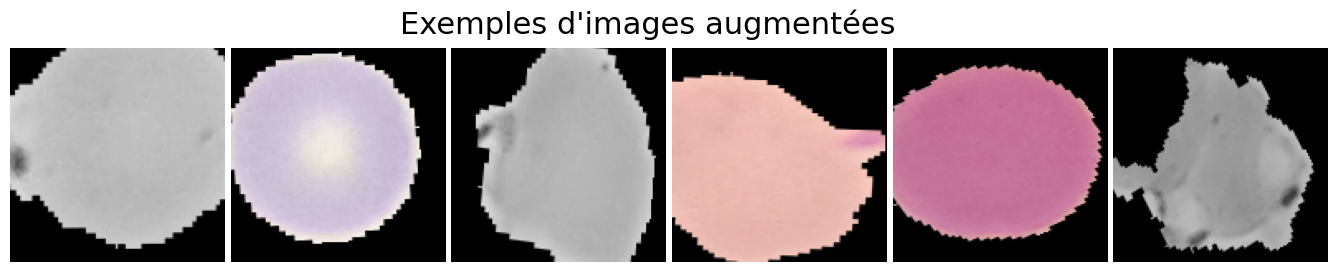

In [12]:
# 5) On récupère un batch aléatoire d'images
images, labels = next(train_generator)

# Vérifier si les images sont en niveaux de gris ou en couleur
is_grayscale = images.shape[-1] == 1  # Vérifie si le dernier canal est 1 (grayscale)

# Affichage avec des images mélangées
fig, axes = plt.subplots(1, 6, figsize=(17, 3))

for i in range(6):
    if is_grayscale:
        axes[i].imshow(images[i].squeeze(), cmap="gray")
    else:
        axes[i].imshow(images[i])  # Affichage normal pour les images en couleur

    axes[i].axis("off")

plt.suptitle("Exemples d'images augmentées", fontsize=22)
plt.subplots_adjust(wspace=0.03)
plt.show()

In [13]:
# 6) Préparation avant l’entraînement - détermine le nombre de classes à partir du générateur binaire ou multi-classes
num_classes = len(train_generator.class_indices)  # 2 classes

# Labels sont directement gérés dans train_generator
y_train_cat = train_generator.classes
y_val_cat = val_generator.classes
y_test_cat = test_generator.classes

# Callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    #min_lr=1e-7,
    min_lr=1e-6,
    verbose=1
)
# Vérification des classes
print(f"Classes détectées: {train_generator.class_indices}")
print(f"Nombre de classes: {num_classes}")


Classes détectées: {'parasitized': 0, 'uninfected': 1}
Nombre de classes: 2


In [14]:
# 7) Création de fonctions pour optimiser le code et éviter la redondance + améliorer la structure du code

# Déterminer la forme d'entrée (RGB ou grayscale converti en RGB)
input_shape = (130, 130, 1) if is_grayscale else (130, 130, 3)
# Factorisation des Callbacks
def get_callbacks(model_name="model"):
    return [
        ModelCheckpoint(f'best_{model_name}.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, verbose=1),
        EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
    ]

# Fonction de compilation pour éviter les répétitions
def compile_model(model, learning_rate):
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

# Fonction d'entraînement
def train_model(model, train_generator, val_generator, epochs=20, model_name="model"):
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs,
        callbacks=get_callbacks(model_name)
    )
    return history

# Modèle from scratch

Ajout de couches Dense dans le fullyconnected, car le modèle était sous-entraîné au départ.
Utilisation de GlobalAverage au lieu de flatten() car il réduit le nombre de paramètres, limite l'overfitting et améliore la généralisation et surtout ça nous a permis de résuire la consommation de la RAM.

In [26]:
# 8) Modèle from scratch

def build_model_from_scratch():
    model = models.Sequential([
        # Première couche de convolution avec Dropout
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2,2)),
        #layers.Dropout(0.1),

        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.2),

        layers.Conv2D(128, (5,5), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.3),

        layers.Conv2D(256, (5,5), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),

        # Passage au classifieur avec GlobalAveragePooling moins de paramètre que avec flatten()
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
        layers.Dropout(0.3),
        layers.Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
        layers.Dropout(0.2),
        layers.Dense(1, activation='sigmoid'),  # Classification binaire
    ])

    compile_model(model, learning_rate=0.0001)
    return model

model1 = build_model_from_scratch()
model1.summary()

history1 = train_model(model1, train_generator, val_generator, epochs=100, model_name="from_scratch")

# Évaluation sur le test
test_loss, test_acc = model1.evaluate(test_generator)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 62, 62, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 31, 31, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 31, 31, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 27, 27, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 27, 27, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 13, 13, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 13, 13, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 9, 9, 256)           │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 9, 9, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,308,481 (4.99 MB)

 Trainable params: 1,307,713 (4.99 MB)

 Non-trainable params: 768 (3.00 KB)

Epoch 1/100
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 599ms/step - accuracy: 0.5874 - loss: 1.3454
Epoch 1: val_loss improved from inf to 1.31419, saving model to best_from_scratch.keras
145/145 ━━━━━━━━━━━━━━━━━━━━ 102s 647ms/step - accuracy: 0.5876 - loss: 1.3451 - val_accuracy: 0.4999 - val_loss: 1.3142 - learning_rate: 1.0000e-04
Epoch 2/100
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 601ms/step - accuracy: 0.6813 - loss: 1.1781
Epoch 2: val_loss improved from 1.31419 to 1.30715, saving model to best_from_scratch.keras
145/145 ━━━━━━━━━━━━━━━━━━━━ 92s 637ms/step - accuracy: 0.6814 - loss: 1.1779 - val_accuracy: 0.4999 - val_loss: 1.3071 - learning_rate: 1.0000e-04
Epoch 3/100
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 604ms/step - accuracy: 0.7287 - loss: 1.0575
Epoch 3: val_loss improved from 1.30715 to 1.13456, saving model to best_from_scratch.keras
145/145 ━━━━━━━━━━━━━━━━━━━━ 93s 639ms/step - accuracy: 0.7288 - loss: 1.0573 - val_accuracy: 0.5030 - val_loss: 1.1346 - learning_rate: 1.0000e-04
Epoch 4/100
145/

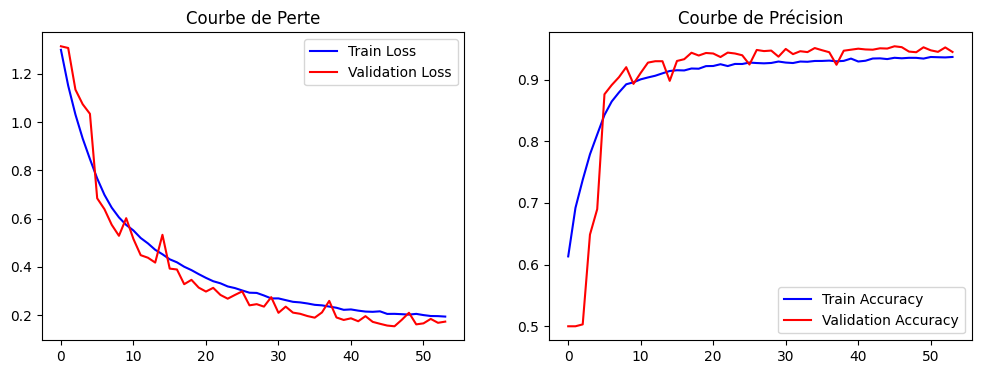

In [28]:
def plot_history(history):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    # Courbe de perte (Loss)
    axs[0].plot(history.history['loss'], label='Train Loss', color='blue')
    axs[0].plot(history.history['val_loss'], label='Validation Loss', color='red')
    axs[0].set_title('Courbe de Perte')
    axs[0].legend()

    # Courbe d’accuracy
    axs[1].plot(history.history['accuracy'], label='Train Accuracy', color='blue')
    axs[1].plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
    axs[1].set_title('Courbe de Précision')
    axs[1].legend()

    plt.show()

# Appel de la fonction après entraînement du modèle
plot_history(history1)


* On observe que l'accuracy du modèle from scratch est élevée à 95.85% ce qui signifie que notre modèle est capable de bien prédire les classes avec une accuracy et une faible erreur.

* La courbe de précision monte jusqu'à 90% puis elle se stabilise, dans l'ensemble,le modèle semble bien converger et apprendre correctmeent sasn trop montrer des signes d'overfitting.
Notre modèle à l'air fiable pour effectuer des prédictions précises sur des images similaires à celles de l’ensemble de test.

#Fine tuning Vgg16 & Resnet50
Au départ, on avait du mal à comprendre quelle partie du modèle était utilisée pour mesurer sa performance par rapport aux deux autres modèles. De plus, le pré-entraînement et le fine-tuning n’étaient pas complètement compris.

Au début, on écrivait le code comme indiqué dans le TP en gelant les couches, mais les résultats n’étaient pas bons et on observait de l’overfitting. On a tenté d’ajuster certains paramètres, mais rien n’y faisait. Après nous s’être documentés, on a compris que le fine-tuning n’était pas déclenché, car on utilisait uniquement les connaissances générales du modèle.

Il fallait donc débloquer quelques-unes des dernières couches pour qu’elles s’adaptent à notre dataset. On a trouvé que dégeler 10 couches était un choix raisonnable, car notre dataset contient 27 558 images. Selon la taille moyenne du dataset, dégeler trop de couches risquait de provoquer de l’overfitting.


In [17]:
# 9) Modèle VGG16
# Construction et affichage du modèle

def build_model_vgg16():
    # Charger VGG16 pré-entraîné sans les couches
    vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # Geler les poids du VGG16 pour ne pas entraîner l'encodeur
    for layer in vgg_base.layers:
        layer.trainable = False

    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Lambda(preprocess_input),  # Normalisation pour VGG16

        vgg_base,  # Encodeur VGG16

        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.3),  # Ajout de Dropout pour régularisation
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.2),  # Régularisation
        layers.Dense(1, activation='sigmoid')  # Classification binaire
    ])
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

model_vgg16 = build_model_vgg16()
model_vgg16.summary()
history_vgg16 = train_model(model_vgg16, train_generator, val_generator, epochs=20, model_name="vgg16")

# Activation du fine-tuning 10 dernières couches du VGG16
vgg_base = model_vgg16.layers[1]
for layer in vgg_base.layers[-13:]:
    layer.trainable = True

# Recompiler le modèle après activation des dernières couches
model_vgg16.compile(optimizer=Adam(learning_rate=3e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Fine-tuning des couches supérieures du VGG16
history_finetune = train_model(model_vgg16, train_generator, val_generator, epochs=85, model_name="vgg16_finetune")

# Évaluation finale sur le test
test_loss, test_acc = model_vgg16.evaluate(test_generator)
print(f"Test accuracy: {test_acc:.4f} - Test loss: {test_loss:.4f}")


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                      │ (None, 130, 130, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 4, 4, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,108,929 (57.64 MB)

 Trainable params: 394,241 (1.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 602ms/step - accuracy: 0.4977 - loss: 0.8234
Epoch 1: val_loss improved from inf to 0.69100, saving model to best_vgg16.keras
145/145 ━━━━━━━━━━━━━━━━━━━━ 117s 667ms/step - accuracy: 0.4977 - loss: 0.8232 - val_accuracy: 0.5001 - val_loss: 0.6910 - learning_rate: 1.0000e-04
Epoch 2/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 608ms/step - accuracy: 0.5082 - loss: 0.7334
Epoch 2: val_loss improved from 0.69100 to 0.68788, saving model to best_vgg16.keras
145/145 ━━━━━━━━━━━━━━━━━━━━ 94s 645ms/step - accuracy: 0.5082 - loss: 0.7334 - val_accuracy: 0.5817 - val_loss: 0.6879 - learning_rate: 1.0000e-04
Epoch 3/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 604ms/step - accuracy: 0.5184 - loss: 0.7106
Epoch 3: val_loss improved from 0.68788 to 0.68658, saving model to best_vgg16.keras
145/145 ━━━━━━━━━━━━━━━━━━━━ 93s 642ms/step - accuracy: 0.5184 - loss: 0.7106 - val_accuracy: 0.5509 - val_loss: 0.6866 - learning_rate: 1.0000e-04
Epoch 4/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 

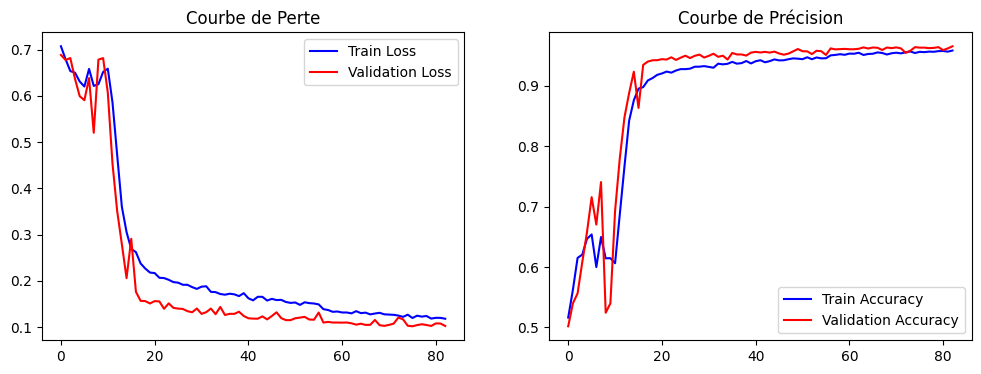

In [18]:
def plot_vgg(history):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    # Courbe de perte (Loss)
    axs[0].plot(history.history['loss'], label='Train Loss', color='blue')
    axs[0].plot(history.history['val_loss'], label='Validation Loss', color='red')
    axs[0].set_title('Courbe de Perte')
    axs[0].legend()

    # Courbe d’accuracy
    axs[1].plot(history.history['accuracy'], label='Train Accuracy', color='blue')
    axs[1].plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
    axs[1].set_title('Courbe de Précision')
    axs[1].legend()

    plt.show()

# Appel de la fonction après entraînement du modèle

plot_vgg(history_finetune)

* Avec 96% d'accuracy, le modèle Vgg16 est bien entrainé et l'on voit de très bons résultats. Il apprend vite et généralise bien aux nouvelles données.

# Recompilation du Fine tuning
On recompile après avoir dégelé les couches du modèle Vgg16 & ResNet50.
Sinon l’optimizer saura pas qu’il doit entraîner les nouvelles couches.



In [19]:
# 10) Fine-tuning du ResNet50
def build_model_resnet():
    resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    # Geler toutes les couches du ResNet50
    for layer in resnet_base.layers:
        layer.trainable = False

    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Lambda(preprocess_input),  # Normalisation pour ResNet50
        resnet_base,

        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(1, activation='sigmoid')  # Classification binaire
    ])

    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

model_resnet = build_model_resnet()
model_resnet.summary()
history_resnet = train_model(model_resnet, train_generator, val_generator, epochs=25, model_name="resnet")

# Activation du fine-tuning
resnet_base = model_resnet.layers[1]
for layer in resnet_base.layers[-30:]:
    if isinstance(layer, layers.Conv2D):
        layer.kernel_regularizer = l2(0.001)  # Applique L2 aux couches convolutives
    layer.trainable = True  # # Dégeler les dernières couches

# Recompiler après le fine-tuning
model_resnet.compile(optimizer=Adam(learning_rate=5e-5), loss='binary_crossentropy', metrics=['accuracy'])

history_finetune_resnet = train_model(model_resnet, train_generator, val_generator, epochs=20, model_name="resnet_finetune")

#Ajout un autre phase pour éviter la convergence rapide
model_resnet.compile(optimizer=Adam(learning_rate=2e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Ajout d'un callback pour ajuster dynamiquement le learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

history_finetune_resnet = model_resnet.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    callbacks=[reduce_lr]
)
# Évaluation finale sur le test
test_loss, test_acc = model_resnet.evaluate(test_generator)
print(f"Test accuracy: {test_acc:.4f} - Test loss: {test_loss:.4f}")



94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lambda_1 (Lambda)                    │ (None, 130, 130, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 5, 5, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,771,457 (94.50 MB)

 Trainable params: 1,182,209 (4.51 MB)

 Non-trainable params: 23,589,248 (89.99 MB)

Epoch 1/25
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 603ms/step - accuracy: 0.5855 - loss: 1.8202
Epoch 1: val_loss improved from inf to 1.44621, saving model to best_resnet.keras
145/145 ━━━━━━━━━━━━━━━━━━━━ 119s 701ms/step - accuracy: 0.5856 - loss: 1.8192 - val_accuracy: 0.6244 - val_loss: 1.4462 - learning_rate: 1.0000e-04
Epoch 2/25
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 608ms/step - accuracy: 0.6188 - loss: 1.4143
Epoch 2: val_loss improved from 1.44621 to 1.21851, saving model to best_resnet.keras
145/145 ━━━━━━━━━━━━━━━━━━━━ 94s 651ms/step - accuracy: 0.6189 - loss: 1.4139 - val_accuracy: 0.6955 - val_loss: 1.2185 - learning_rate: 1.0000e-04
Epoch 3/25
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 603ms/step - accuracy: 0.6296 - loss: 1.2374
Epoch 3: val_loss improved from 1.21851 to 1.07969, saving model to best_resnet.keras
145/145 ━━━━━━━━━━━━━━━━━━━━ 94s 645ms/step - accuracy: 0.6296 - loss: 1.2371 - val_accuracy: 0.7101 - val_loss: 1.0797 - learning_rate: 1.0000e-04
Epoch 4/25
145/145 ━━━━━━━━━━━━━━━━━━

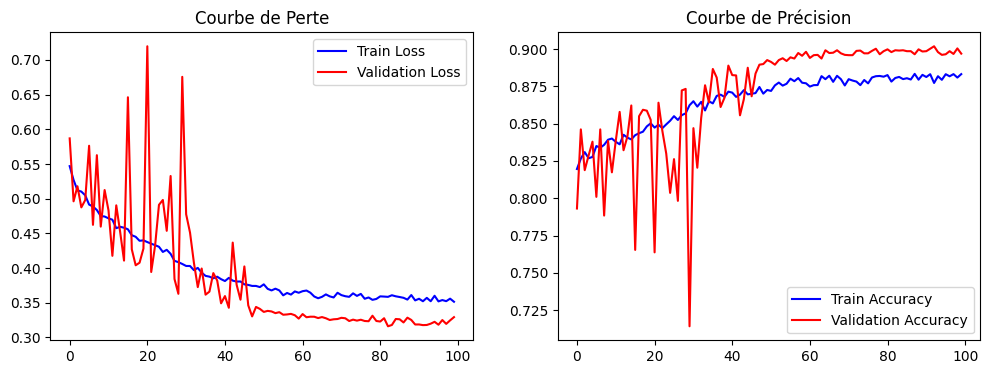

In [20]:
import matplotlib.pyplot as plt

def plot_history(history):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    # Courbe de perte
    axs[0].plot(history.history['loss'], label='Train Loss', color='blue')
    axs[0].plot(history.history['val_loss'], label='Validation Loss', color='red')
    axs[0].set_title('Courbe de Perte')
    axs[0].legend()

    # Courbe de précision
    axs[1].plot(history.history['accuracy'], label='Train Accuracy', color='blue')
    axs[1].plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
    axs[1].set_title('Courbe de Précision')
    axs[1].legend()

    plt.show()

plot_history(history_finetune_resnet)


* On voit que la courbe de perte d'entrainement et de validation diminuent progressivement ce qui peut signifier que modèle apprend bien.
* La courbe de précision du modèle sur l'ensemble d'entrainement et de validation augmente au fur et à mesure des epocs. Cependant, on remarque qu'il y a des variations dans les 2 courbes ce qui peut nous indiquer que le modèle à un peu du mal à généralliser.


## Affichage de la courbe ROC et calcule de l'AUC pour chaque modèle.

33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step


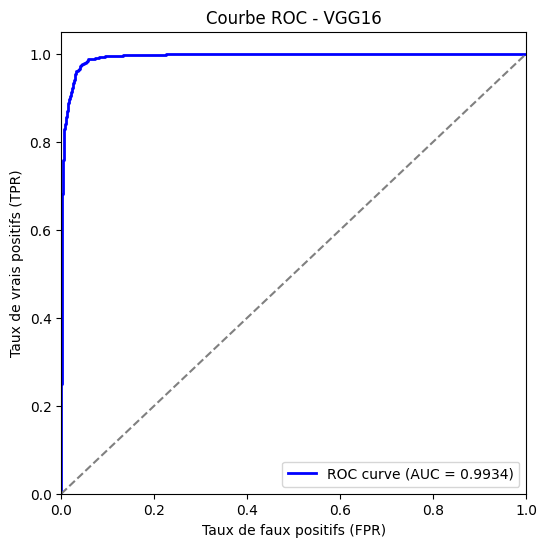

AUC de VGG16 : 0.9934
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step


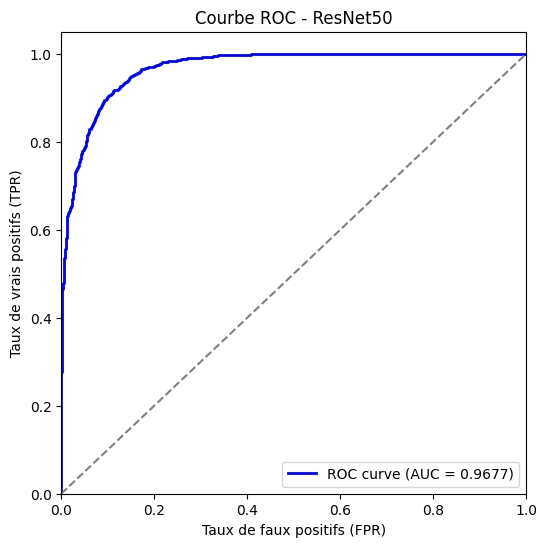

AUC de ResNet50 : 0.9677
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step


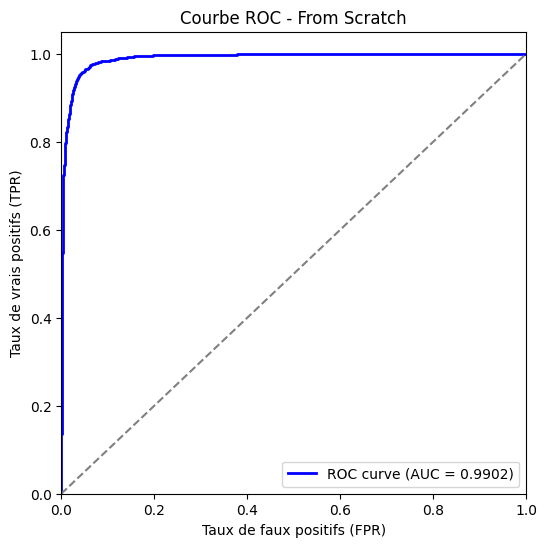

AUC de From Scratch : 0.9902


In [29]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(model, test_generator, model_name):

    # Prédictions sur le jeu de test
    y_true = test_generator.classes
    y_pred = model.predict(test_generator)  # Prédictions

    # Calcul de la courbe ROC
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)  # Calcul de l'AUC

    # Affichage du graphique
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Ligne diagonale
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taux de faux positifs (FPR)')
    plt.ylabel('Taux de vrais positifs (TPR)')
    plt.title(f'Courbe ROC - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

    print(f"AUC de {model_name} : {roc_auc:.4f}")

# Affichage des courbes ROC et calcul des AUC pour les 3 modèles
plot_roc_curve(model_vgg16, test_generator, "VGG16")
plot_roc_curve(model_resnet, test_generator, "ResNet50")
plot_roc_curve(model1, test_generator, "From Scratch")


## Courbes ROC et AUC
* Courbe VGG16 : AUC est de 0,9934%, modèle très performant pour distinguer les classes.
* Courbe Resnet50 : AUC est proche de 1 ce qui signifie que le modèle est performant et fait peu d'erreurs en général.
* Courbe From scratch : AUC est ptoche de 1 ce qui indique une très bonne distinction entre les classes.   

# Affichage de la matrice de confusion pour chaque modèle


33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step


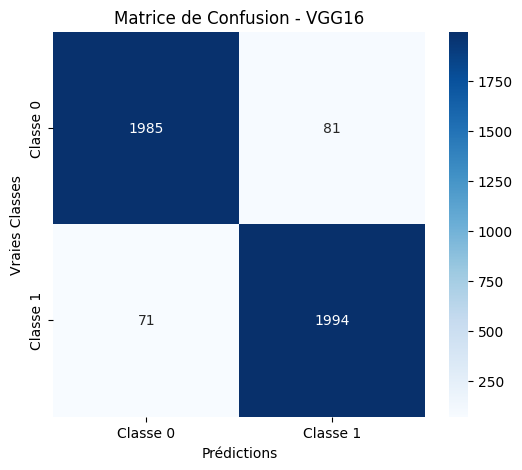

33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step


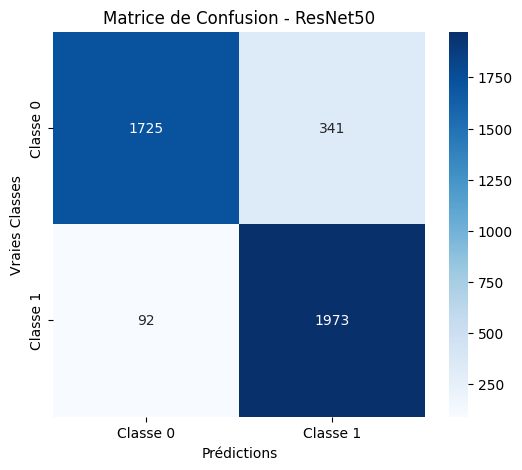

33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step


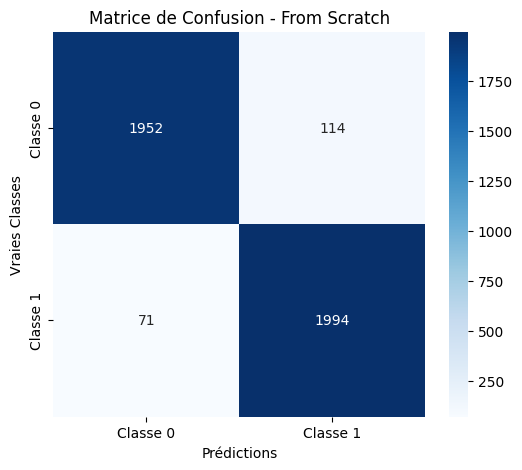

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(model, test_generator, model_name):
    # Prédictions du modèle
    y_pred_probs = model.predict(test_generator)

    # Convertir les probabilités en classes binaires
    y_pred = (y_pred_probs > 0.5).astype(int)

    # Récupérer les vraies classes
    y_true = test_generator.classes

    # Calcul de la matrice de confusion
    cm = confusion_matrix(y_true, y_pred)

    # Affichage de la matrice de confusion
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Classe 0', 'Classe 1'], yticklabels=['Classe 0', 'Classe 1'])
    plt.xlabel("Prédictions")
    plt.ylabel("Vraies Classes")
    plt.title(f"Matrice de Confusion - {model_name}")
    plt.show()

# Affichage des matrices de confusion pour les 3 modèles
plot_confusion_matrix(model_vgg16, test_generator, "VGG16")
plot_confusion_matrix(model_resnet, test_generator, "ResNet50")
plot_confusion_matrix(model1, test_generator, "From Scratch")


# Matrices de confusion
* VGG16 : le modèle classe bien 1985 images, 81 faux positifs des sains classés comme inféctés. Pour la classe 1, 1994 images bien classés, 71 faux négatifs, il y a très peu d'erreurs donc un bon équilibre dans les prédictions.
* Resnet50 : le modèle a bien classé 1725 images de la classe 0 correctement mais il s'est trompé 341 fois en les classant comme infectées.
* From Scratch : le modèle classfie correctement 1952 images de la classe 0 et 1994 images de la classe 1, 114 faux positifs et 71 erreurs de faux néfatifs.

# Calcule des métriques de performance de chaque modèle

In [31]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

def evaluate_model(model, test_generator, model_name):
    # Prédictions du modèle (probabilités)
    y_pred_probs = model.predict(test_generator)

    # Convertir les probabilités en classes binaires (0 ou 1)
    y_pred = (y_pred_probs > 0.5).astype(int).flatten()

    # Récupérer les vraies classes
    y_true = test_generator.classes

    # Calcul de la matrice de confusion
    cm = confusion_matrix(y_true, y_pred)
    TN, FP, FN, TP = cm.ravel()

    # Calcul des métriques
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    specificity = TN / (TN + FP)  # Calcul manuel de la spécificité

    # Affichage des résultats
    print(f" **Métriques pour {model_name}**")
    print(f" Accuracy        : {accuracy:.4f}")
    print(f" Precision       : {precision:.4f}")
    print(f" Recall (Sensibilité) : {recall:.4f}")
    print(f" F1-score        : {f1:.4f}")
    print(f" Spécificité     : {specificity:.4f}")
    print("\n Rapport de classification :\n", classification_report(y_true, y_pred))

# Évaluation pour les 3 modèles
evaluate_model(model_vgg16, test_generator, "VGG16")
evaluate_model(model_resnet, test_generator, "ResNet50")
evaluate_model(model1, test_generator, "From Scratch")


33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step
 **Métriques pour VGG16**
 Accuracy        : 0.9632
 Precision       : 0.9610
 Recall (Sensibilité) : 0.9656
 F1-score        : 0.9633
 Spécificité     : 0.9608

 Rapport de classification :
               precision    recall  f1-score   support

           0       0.97      0.96      0.96      2066
           1       0.96      0.97      0.96      2065

    accuracy                           0.96      4131
   macro avg       0.96      0.96      0.96      4131
weighted avg       0.96      0.96      0.96      4131

33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step
 **Métriques pour ResNet50**
 Accuracy        : 0.8952
 Precision       : 0.8526
 Recall (Sensibilité) : 0.9554
 F1-score        : 0.9011
 Spécificité     : 0.8349

 Rapport de classification :
               precision    recall  f1-score   support

           0       0.95      0.83      0.89      2066
           1       0.85      0.96      0.90      2065

    accuracy                           0

## Conclusion et observations finales



# Modèle VGG16


> Le modèle VGG16 fonctionne très bien avec une précision élevée. Il détecte bien les cas infectés et non infectés avec peu d'erreurs. Sa matrice de confusion montre peu de faux positifs et faux négatifs.



# Modèle Resnet50


> ResNet50 est moins précis que VGG16 et a plus d’erreurs, surtout sur les images non infectées. Il sacrifie un peu la précision pour mieux détecter les cas infectés. Cela peut être utile si on veut minimiser le risque de rater une infection, mais il génère plus de fausses alertes.



# Modèle From Scratch


>Le modèle entraîné from scratch fait un excellent travail, proche de VGG16. Il a un meilleur recall que VGG16, ce qui veut dire qu’il détecte encore plus d’infections, mais il a un peu plus de faux positifs. Il est un bon compromis entre VGG16 et ResNet50.

